In [394]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

#import sys
#!{sys.executable} -m pip install <package catboost>

In [395]:
data = pd.read_csv('train.csv',index_col=False)
test = pd.read_csv('test.csv',index_col=False)
submission_df = pd.DataFrame()
submission_df['id'] = test['id']

In [396]:
target = 'is_cancelled'
seed = 78

In [397]:
data['test'] = 'Test'
test['test'] = 'Train'
concatenated_df = pd.concat([data, test], axis=0)

# 1. EDA

In [423]:
data.head()

,lead_time,arrival_week,duration,prev_cancel,booking_changes,waiting_period,per_Day_price,parking,special_request,segment,deposit,cust_type,is_cancelled
0,245,13,5,0,0,0,78.26,0,1,Online TA,No Deposit,Transient,0
1,170,25,2,0,0,0,130.50,0,0,Online TA,No Deposit,Transient,0
2,304,45,3,0,0,0,89.00,0,0,Offline TA/TO,Non Refund,Transient,1
3,19,7,1,0,0,0,82.13,0,1,Online TA,No Deposit,Transient,0
4,214,27,4,0,0,0,89.10,0,1,Other,No Deposit,Transient-Party,0


In [421]:
data.describe().round(2)

,lead_time,duration,booking_changes,per_Day_price,special_request,is_cancelled
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,110.87,2.15,0.19,104.66,0.39,0.41
std,112.82,1.28,0.57,38.30,0.49,0.49
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,23.00,1.00,0.00,79.00,0.00,0.00
50%,75.00,2.00,0.00,99.00,0.00,0.00
75%,166.00,3.00,0.00,125.00,1.00,1.00
max,629.00,6.00,13.00,313.67,1.00,1.00


In [422]:
test.describe().round(2)

,lead_time,duration,booking_changes,per_Day_price,special_request
count,1000.00,1000.00,1000.00,1000.00,1000.00
mean,109.08,2.21,0.19,103.46,0.50
std,108.13,1.62,0.72,40.27,0.74
min,0.00,0.00,0.00,0.00,0.00
25%,23.00,1.00,0.00,76.50,0.00
50%,77.00,2.00,0.00,98.44,0.00
75%,161.00,3.00,0.00,124.66,1.00
max,605.00,22.00,16.00,285.00,4.00


#### Missing Values

In [419]:
print(data.isna().sum().sum())
print(test.isna().sum().sum())

0
0


## Effect of Numerical Variables on Target

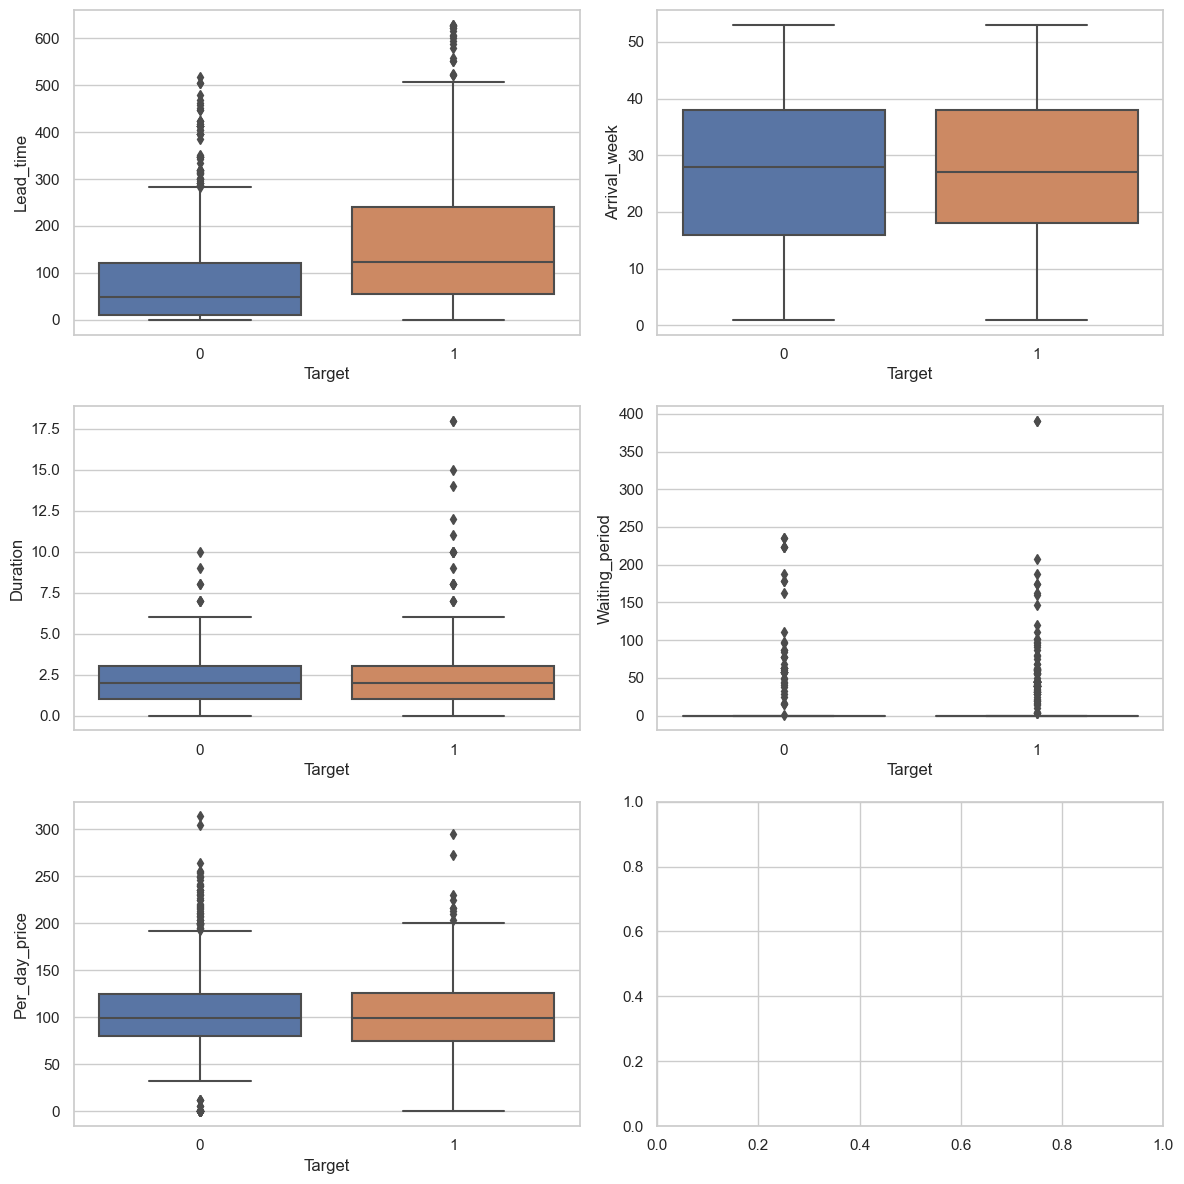

In [398]:
num_cols = ['lead_time', 'arrival_week', 'duration', 'waiting_period', 'per_Day_price']

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

axes = axes.flatten()

for i, num_col in enumerate(num_cols):
    sns.boxplot(x=target, y=num_col, data=data, ax=axes[i])
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(f'{num_col.capitalize()}')

plt.tight_layout()
plt.show()


- The average lead time for cancelled bookings is relatively longer for cancelled bookings compared to that of non cancelled bookings
- The distributions for other numerical columns are identical across both classes. These columns might not directly affect the target, but in interaction with other features, can definitely increase model performance.
- Columns like lead_time, duration, waiting_period, per_day_price all have numerous outliers. Since there are too many, we can't remove all those observations

## Effect of Categorical Variables on Target

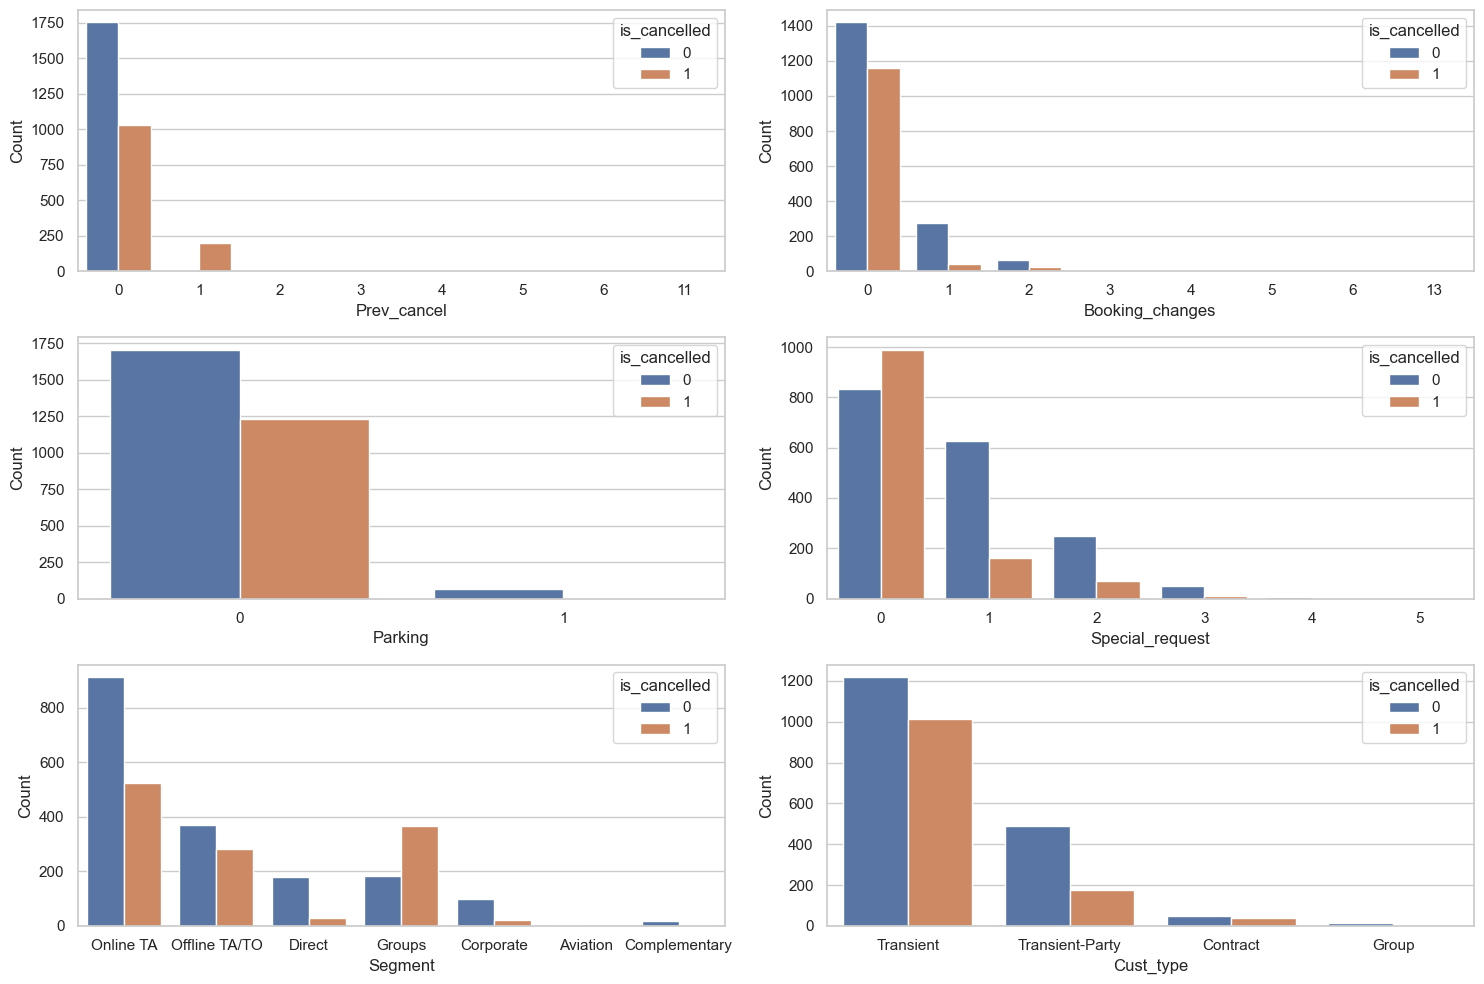

In [399]:
cat_cols = ['prev_cancel', 'booking_changes', 'parking', 'special_request', 'segment', 'cust_type']

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()

for i, cat_col in enumerate(cat_cols):
    sns.countplot(x=cat_col, hue=target, data=data, ax=axes[i])
    axes[i].set_xlabel(f'{cat_col.capitalize()}')
    axes[i].set_ylabel('Count')
    axes[i].legend(title='is_cancelled')

# Adjust layout
plt.tight_layout()
plt.show()


Prev_cancel
- Customers who have cancelled before are more likely to cancel again, compared to customers who haven't cancelled before

Booking_changes and Special Request
- Customers who have made 1 booking change are less likely to cancel compared to customers who have made zero booking changes. Although we don't have a similar number of observations in both the groups, this makes logical sense as people who have made a change are more serious about their plans while the other group might have more tentative plans. 

- The same is true for people who have made a special request. These customers have more concrete plans and hence are less likely to cancel.

Segment
- Both `Groups` and `Offline TA/TO` have high cancellation rates

Cust_type
- `Transient` and 'Contract' customers have high cancellation rates

### Deposit seems to be an important feature. But the data looks odd

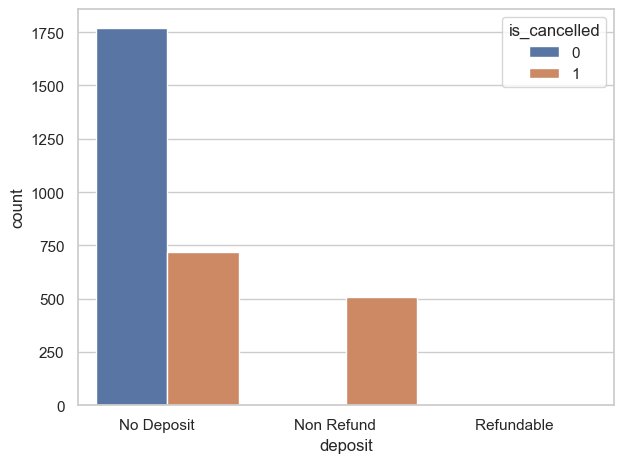

In [400]:
sns.countplot(x='deposit', hue=target, data=data)
plt.tight_layout()
plt.show()

In [401]:
cross = pd.crosstab(data['deposit'], data[target])
cross

is_cancelled,0,1
deposit,,
No Deposit,1770,720
Non Refund,0,509
Refundable,1,0


- This is quite strange as there are literally zero observations of customers who have not cancelled when the deposit is non-refundable. One would expect the complete opposite; because of the non refundable deposit, most customers would NOT cancel their booking.

- I would verify the source of the data if possible. This might be a data entry or data annotation mistake. Or maybe we are missing a lot of observations about non refundable bookings belonging to class 0. 

- Nonetheless, having such disparity in the data can be a valuable feature in terms of modelling. I would, however, consider any predictive gain from this feature with a grain of salt.

## Comparing distribution of training and testing data for numerical columns

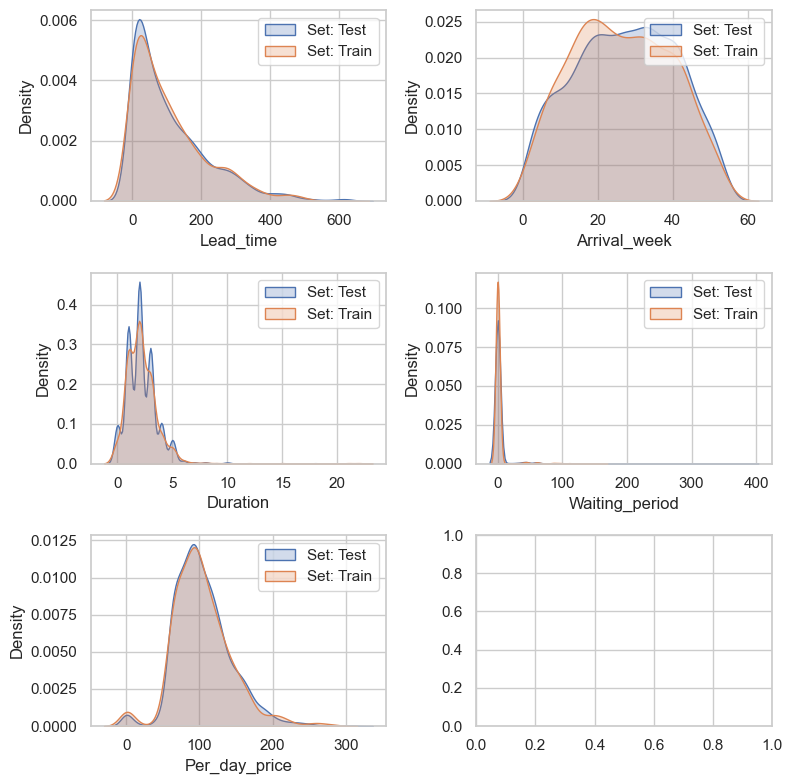

In [402]:
num_cols = ['lead_time', 'arrival_week', 'duration', 'waiting_period', 'per_Day_price']
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
axes = axes.flatten()


for i, num_col in enumerate(num_cols):
    for target_class in concatenated_df['test'].unique():
        sns.kdeplot(data=concatenated_df[concatenated_df['test'] == target_class][num_col], ax=axes[i], label=f'Set: {target_class}', fill=True)
    axes[i].set_xlabel(f'{num_col.capitalize()}')
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()


### The distributions of numerical columns look identical across both the training and testing sets. 

# Comparing distribution of training and testing data for categorical columns

In [403]:

cat_cols = ['prev_cancel', 'booking_changes', 'parking', 'special_request', 'segment', 'cust_type']

dfs = {}

for col in cat_cols:
    train_proportions = concatenated_df[concatenated_df['test'] == 'Train'][col].value_counts(normalize=True).reset_index()
    train_proportions.columns = [col, 'Train']
    
    test_proportions = concatenated_df[concatenated_df['test'] == 'Test'][col].value_counts(normalize=True).reset_index()
    test_proportions.columns = [col, 'Test']
    
    merged_df = pd.merge(train_proportions, test_proportions, on=col, how='outer')
    
    merged_df.fillna(0, inplace=True)
    merged_df['Train'] *= 100
    merged_df['Test'] *= 100
    
    dfs[col] = merged_df


for col, df_cat in dfs.items():
    display(df_cat.round(2))
    print()


,prev_cancel,Train,Test
0,0,92.8,92.77
1,1,7.0,6.87
2,11,0.1,0.03
3,2,0.1,0.07
4,3,0.0,0.13
5,6,0.0,0.07
6,4,0.0,0.03
7,5,0.0,0.03


,booking_changes,Train,Test
0,0,87.3,86.00
1,1,9.0,10.43
2,2,2.7,2.90
3,3,0.7,0.40
4,4,0.1,0.17
5,16,0.1,0.00
6,5,0.1,0.03
7,13,0.0,0.03
8,6,0.0,0.03


,parking,Train,Test
0,0,97.8,97.77
1,1,2.2,2.23


,special_request,Train,Test
0,0,62.9,60.80
1,1,26.1,26.27
2,2,9.3,10.60
3,3,1.6,2.07
4,4,0.1,0.23
5,5,0.0,0.03


,segment,Train,Test
0,Online TA,49.9,47.97
1,Offline TA/TO,20.2,21.73
2,Groups,17.5,18.37
3,Direct,7.6,7.03
4,Corporate,3.2,4.07
5,Complementary,1.1,0.67
6,Aviation,0.5,0.17


,cust_type,Train,Test
0,Transient,75.9,74.37
1,Transient-Party,21.0,22.13
2,Contract,2.7,2.97
3,Group,0.4,0.53


### The proportions of all categorical columns also look indentical across both the training and testing sets. 

### Training and Testing data have similar characteristics. This gives us confidence that the model performance in testing should be similar to it's performance in training

# 2. Preprocessing Feature Engineering

In [404]:
data['special_request'] = data['special_request'].apply(lambda x: 0 if x == 0 else 1)
data['duration'] = data['duration'].apply(lambda x: x if x < 6 else 6)

categories_to_replace = ['Direct', 'Corporate', 'Complementary', 'Aviation']
data['segment'] = data['segment'].replace(categories_to_replace, 'Other')

data['waiting_period'] = data['waiting_period'].apply(lambda x: 0 if x == 0 else 1)

data['prev_cancel'] = data['prev_cancel'].apply(lambda x: 0 if x == 0 else 1)

In [405]:
cat_cols = ['arrival_week','parking','segment','deposit','cust_type','prev_cancel','waiting_period']

for col in cat_cols:
    data[col] = data[col].astype('category')
    test[col] = test[col].astype('category')

In [406]:
drop_cols = []
drop_cols.append('id')
drop_cols.append('Unnamed: 0')
drop_cols.append('test')

In [407]:
data.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

In [408]:
categorical_columns = data.select_dtypes(include=['category']).columns.tolist()

In [409]:
y = data[target]
x = data.drop([target],axis=1)

# 3. Model Training

In [410]:
folds = 5
train_scores = []
test_scores = []
feature_importances = []


skf = StratifiedKFold(n_splits=folds, random_state=seed, shuffle=True)

for train_index, test_index in skf.split(x, y):
    
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    model = CatBoostClassifier(verbose=0, random_state=seed, cat_features=categorical_columns, max_depth=6)
    model.fit(x_train, y_train)

    train_pred_proba = model.predict_proba(x_train)[:, 1]
    test_pred_proba = model.predict_proba(x_test)[:, 1]  
    
    train_pred = np.where(train_pred_proba >= 0.5, 1, 0)
    test_pred = np.where(test_pred_proba >= 0.5, 1, 0)
    
    train_score = round(accuracy_score(y_train, train_pred), 4)
    test_score = round(accuracy_score(y_test, test_pred), 4)

    print(f"Fold {len(train_scores)+1}")
    print(f'Train Accuracy: {train_score*100}')
    print(f'Test Accuracy: {test_score*100}')
    print('-'*15)

    train_scores.append(train_score)
    test_scores.append(test_score)
    feature_importances.append(model.feature_importances_)
    

print(f"Training average = {round(np.mean(train_scores), 4)*100}")
print(f"Testing average = {round(np.mean(test_scores), 4)*100}")


Fold 1
Train Accuracy: 85.71
Test Accuracy: 81.83
---------------
Fold 2
Train Accuracy: 86.38
Test Accuracy: 81.17
---------------
Fold 3
Train Accuracy: 85.28999999999999
Test Accuracy: 81.5
---------------
Fold 4
Train Accuracy: 85.42
Test Accuracy: 86.33
---------------
Fold 5
Train Accuracy: 84.88
Test Accuracy: 82.33
---------------
Training average = 85.54
Testing average = 82.63000000000001


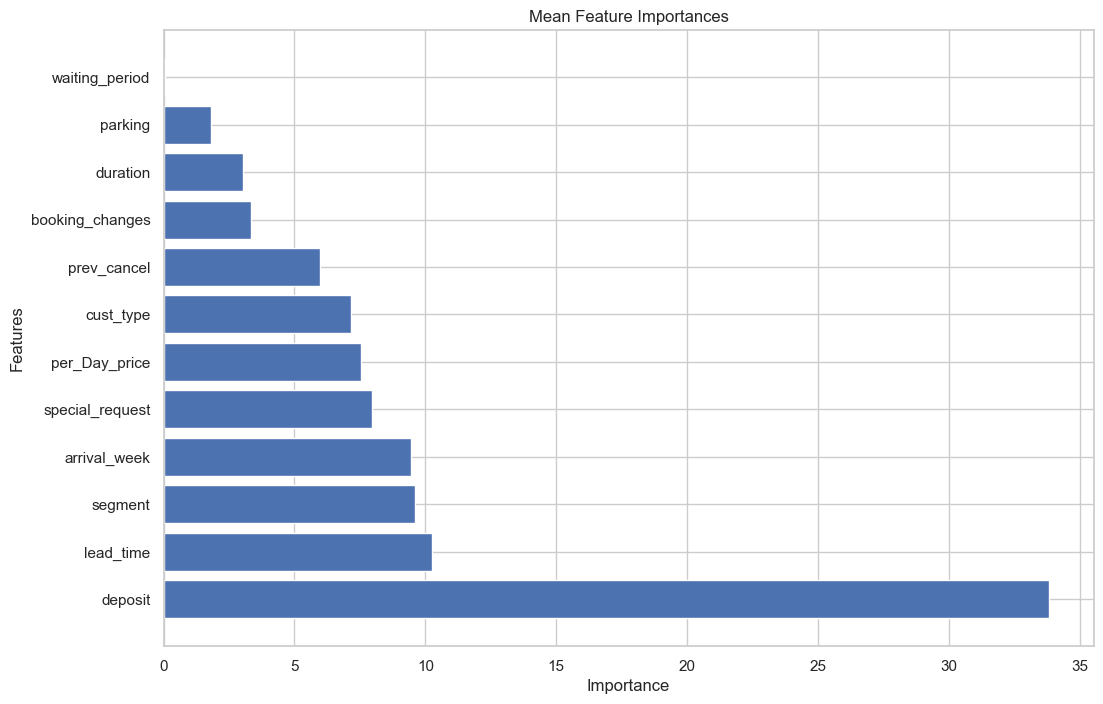

In [411]:
mean_feature_importances = np.mean(feature_importances, axis=0)
sorted_indices = np.argsort(mean_feature_importances)[::-1] 
plt.figure(figsize=(12, 8))
plt.barh(range(len(mean_feature_importances)), mean_feature_importances[sorted_indices], tick_label=x.columns[sorted_indices])
plt.title('Mean Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

- As speculated during EDA, the features deposit, lead_time, special_request and segment are among the most significant features.
- The other features, while not appraently too useful during EDA, also contribute significantly to the model performance

# 4. Submission file

- For predicting on test, I have used the ensemble of the same kfold models used for training.
- Rather than training one model on the entire dataset, I am using training 5 different models on 5 different subsets of data. The idea is to get a generalized approach that doesn't overfit.
- I take a simple average of the probabilities of all 5 models before applying argmax.

In [412]:
folds = 5
pred = np.zeros(shape=(len(test),))

skf = StratifiedKFold(n_splits=folds, random_state=seed, shuffle=True)

for train_index, test_index in skf.split(x, y):
    
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(verbose=0, random_state=seed, cat_features=categorical_columns, max_depth=6)
    model.fit(x_train, y_train)
    
    predictions = model.predict_proba(test)[:, 1]
    pred += predictions

In [413]:
pred = pred/folds
submission_df['is_cancelled'] = np.where(pred >= 0.5, 1, 0)
submission_df.to_csv('submissions.csv',index=False)

In [414]:
submission_df

,id,is_cancelled
0,3200,0
1,3201,0
2,3202,0
3,3203,1
4,3204,0
...,...,...
995,4195,0
996,4196,0
997,4197,0
998,4198,0
